In [188]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

In [189]:
clean_filenames_list = []

for filename in os.listdir('/Users/owainpill/Documents/GitHub/SiotDataAnalysis/imageprocessing/processedimages'):
    if filename.endswith(".jpg"):
        # print(filename)
        # print(filename.split('size'))
        name_wo_size = filename.split('size')
        name_wo_jpg = name_wo_size[1].split('.jpg')
        name_cleaned = [name_wo_size[0], name_wo_jpg[0][0:10], datetime.datetime.fromtimestamp(int(name_wo_jpg[0][0:10])).strftime('%Y-%m-%d %H:%M:%S')]## taking only first ten characters as this is epoch time in seconds
        # print(name_cleaned)
        clean_filenames_list.append(name_cleaned)


df = pd.DataFrame(clean_filenames_list, columns=['ycoord', 'epochtime', 'datetime'])
df['ycoord'] = df['ycoord'].astype(int)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['datetime'])
df = df.reset_index(drop=True)
# print(df)

df


,ycoord,epochtime,datetime
0,241,1701727943,2023-12-04 22:12:23
1,2108,1701727956,2023-12-04 22:12:36
2,1683,1701727962,2023-12-04 22:12:42
3,1380,1701727968,2023-12-04 22:12:48
4,1166,1701727974,2023-12-04 22:12:54
...,...,...,...
397,2517,1701779476,2023-12-05 12:31:16
398,2472,1701779482,2023-12-05 12:31:22
399,2474,1701779517,2023-12-05 12:31:57
400,2500,1701779553,2023-12-05 12:32:33


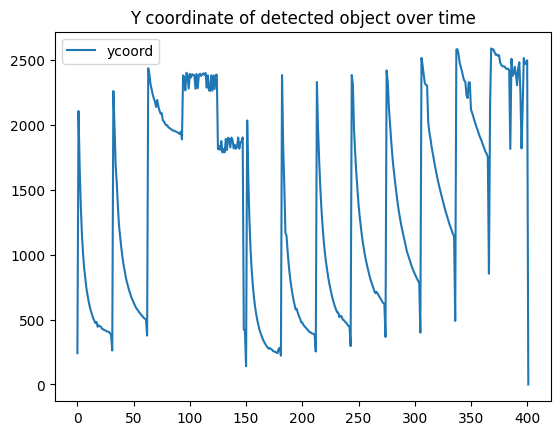

In [190]:
graph = df.plot(y='ycoord', kind='line', title='Y coordinate of detected object over time')#plot position without taking time into account

In [191]:
# df['velocity'] = df['ycoord'].diff() / df['datetime'].diff().dt.total_seconds()
# print(type(df['datetime'][4]))
# %matplotlib inline
# plt.plot(df['datetime'], df['velocity'])

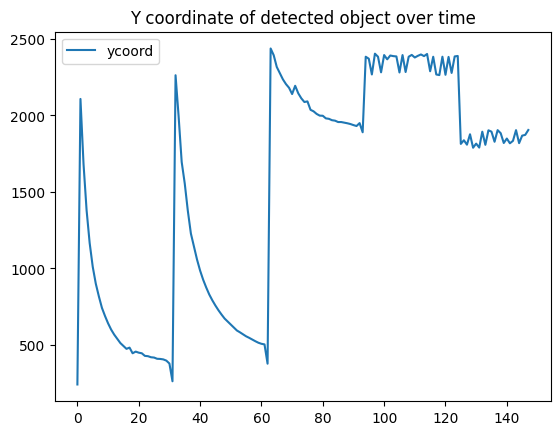

In [192]:
## Split data into different days
# mask = (df['datetime'] > '2023-12-4') & (df['datetime'] <= '2023-12-6')
mask = (df['datetime'] > '2023-12-04 00:00:01') & (df['datetime'] <= '2023-12-04 23:59:59')
df_test1 = df.loc[mask]
graph = df_test1.plot(y='ycoord', kind='line', title='Y coordinate of detected object over time')#plot position without taking time into account

/var/folders/6n/df4bbytx0tqfkq05t0fhwb080000gn/T/ipykernel_54614/1160529095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['timenext'] = df_test1['datetime'].shift(-1)
/var/folders/6n/df4bbytx0tqfkq05t0fhwb080000gn/T/ipykernel_54614/1160529095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1.drop(index+1, inplace=True)
/var/folders/6n/df4bbytx0tqfkq05t0fhwb080000gn/T/ipykernel_54614/1160529095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

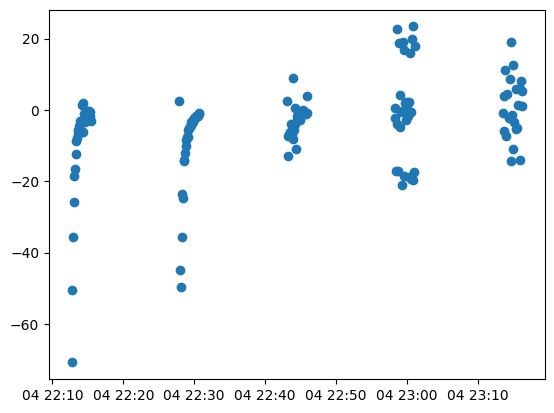

In [193]:
### remove data from the image that is taken just before the printer rotates again - the silicone has had a lot of time to move - hard to get an idea of velocity
df_test1['timenext'] = df_test1['datetime'].shift(-1)

for index, row in df_test1.iterrows():
    # print(index, row['timenext']-row['datetime'])
    if row['timenext']-row['datetime'] > datetime.timedelta(seconds=300):
        # print('found one')
        df_test1.drop(index+1, inplace=True)
    # print(index, row)

df_test1.reset_index(drop=True, inplace=True)


df_test1['velocity'] = df_test1['ycoord'].diff() / df_test1['datetime'].diff().dt.total_seconds()


df_test1['velocity'][1] = np.nan ## first value gets past the other logic check as it does not have a time beofre



plt.scatter(df_test1['datetime'], df_test1['velocity'])

In [194]:
### average out the velocity for each printer rotate

velocities_avg = []
velocities_avg_split =[]


## go through all the timestamps and see where there are big gaps in time - this is where the printer rotates
## then average out the velocities in between these gaps
for index, row in df_test1.iterrows():
    # print(index, row['timenext']-row['datetime'])
    if row['timenext']-row['datetime'] < datetime.timedelta(seconds=300):
        # print('found one')
        velocities_avg.append(row['velocity'])
    else:
        print(velocities_avg)
        velocities_avg_split.append(np.nanmean(velocities_avg))##ignore nan values
        velocities_avg = []

print(velocities_avg_split)

[nan, nan, -70.83333333333333, -50.5, -35.666666666666664, -25.833333333333332, -18.5, -16.6, -12.5, -8.833333333333334, -8.0, -6.833333333333333, -5.5, -4.5, -5.6, -3.1666666666666665, -3.1666666666666665, 1.3333333333333333, -6.166666666666667, 1.8333333333333333, -1.1666666666666667, -0.6666666666666666, -3.4, -0.3333333333333333, -1.1666666666666667, -0.3333333333333333, -1.3333333333333333, -0.16666666666666666, -0.5, -1.6]
[2.5166889185580774, -44.833333333333336, -49.666666666666664, -23.5, -35.6, -24.833333333333332, -14.0, -14.333333333333334, -12.0, -10.0, -8.5, -7.666666666666667, -7.6, -5.666666666666667, -5.166666666666667, -4.666666666666667, -4.333333333333333, -3.3333333333333335, -3.1666666666666665, -3.1666666666666665, -3.3333333333333335, -2.4, -2.1666666666666665, -2.1666666666666665, -1.6666666666666667, -1.8333333333333333, -1.8333333333333333, -1.6666666666666667, -1.1666666666666667]
[2.611336032388664, -7.333333333333333, -12.833333333333334, -6.66666666666666

In [195]:
##Show the location of the average velocities on the graph
%matplotlib tk
plt.scatter(df_test1['datetime'], df_test1['velocity'])

y = np.array(velocities_avg_split)
ticks = ['1', '2', '3', '4', '5']

plt.yticks(y, ticks)

plt.show()